In [1]:
# Importation des librairies

#  visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Tests statistiques
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy import stats

# Sélection des 'features'
from sklearn.feature_selection import f_regression

# Sélection et évaluation des modèles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix


# Prétraitement
from sklearn.preprocessing import StandardScaler

# Algorithmes
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Sauvegarde du modèle
from pathlib import Path
import joblib


## 1 - Exploration et nettoyage des données

In [2]:
df_billets = pd.read_csv(r'C:\Users\orlya\Desktop\Projet 10\billets.csv', sep = ';')

In [3]:
df_billets.head(5)


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### 1.1 Qualité des données

In [4]:
# affiche les dimensions du dataset
df_billets.shape

(1500, 7)

In [5]:
# Affiche les variables
df_billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [6]:
# Affiche le nombre de valeurs uniques
df_billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [7]:
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [8]:
# Suppression des doublons

print('Nombre de doublons supprimer :',len(df_billets) - len(df_billets.drop_duplicates()))

Nombre de doublons supprimer : 0


In [9]:
# Affiche le nombre de valeurs manquantes
df_billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

**Il manque 37 valeurs à margin_low. Avant de mettre en place l'algorithme de détection, il faut d'abord traiter ces valeurs manquantes.**

Plusieurs méthodes existent pour traiter les valeurs manquantes. Dans le cadre de ce projet, c'est la régression linéaire multiple qui a été retenue. Le principe consiste à modéliser une variable dépendante, ici margin_low, grâce à une combinaison linéaire de variables explicatives, ici diagonal, height_left, etc.. Le résultat de la régression permettra ensuite de prédire les valeurs manquantes de margin_low.

Le modèle de la régression doit se baser sur des données de départ ne contenant pas de valeur manquantes il faut donc séparer les enregistrements complets des enregistrements à traiter.


## 2 - Enrichissement des données

In [10]:
# Crée une copie du DataFrame sans valeurs manquantes
df_billets_sans_na = df_billets.loc[
    ~df_billets.isna().any(axis='columns')].copy()

# Affiche le nombre d'enregistrements 
print(f'Dimensions : {df_billets_sans_na.shape}')

# Vérifie si il y des valeurs manquantes
print(f'Valeur(s) manquante(s) : {df_billets_sans_na.isna().any().any()}')

Dimensions : (1463, 7)
Valeur(s) manquante(s) : False


#### 2.1 séparation de la variable independante des variables explicatives

In [11]:
# Définit X et y
y = df_billets_sans_na['margin_low']
X = df_billets_sans_na.drop(columns=['is_genuine', 'margin_low'])

#### 2.2 Apercu des données

*Les variables sont affichées par paires avec les coefficients de corrélation correspondant grâce à la fonction ci-dessous.*

In [12]:
def pairplot_correlation(df, hue=None):
    '''
    Trace les paires de variables et affiche les coefficients de corrélation.
    Paramètres :
    - df = DataFrame source ;
    - hue = variable à différencier (couleur) sur le graphique.
    '''
    # Calcule la matrice de corrélation
    corr_matrix = df.select_dtypes(include='number').corr()

    # Définit le nombre de sous-graphiques et la taille du graphique
    fig, axs = plt.subplots(
        corr_matrix.shape[0], corr_matrix.shape[1], 
        figsize=((corr_matrix.shape[0]*1.4), (corr_matrix.shape[1]*1.2))
    )

    # Boucle sur les lignes et colonnes de la matrice de corrélation
    for i, idx in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            # Affiche le nom des variables
            if i == j:
                axs[i, j].text(x=0.5, y=0.5, s=idx, ha='center', va='center',
                               fontweight='bold')
                
                  # Affiche les coefficients de corrélation
            elif i < j:
                corr_coeff = corr_matrix.loc[idx, col]
                axs[i, j].text(x=0.5, y=0.5, s=f'corr =\n{corr_coeff:.3}',
                               ha='center', va='center')

            # Trace les graphiques
            elif i > j:
                # Trace en fonction de la variable indiquée dans 'hue'
                if hue != None:
                    hue = hue
                    for value in df[hue].unique():
                        axs[i, j].scatter(
                            x=idx, y=col, data=df.loc[df[hue] == value], 
                            marker='.', alpha=0.65, edgecolors='k'
                        )
                        axs[i, j].tick_params(axis='both', labelsize=6.5)

                # Trace sans différenciation
                elif hue == None:
                    axs[i, j].scatter(x=idx, y=col, data=df, marker='.',
                                      edgecolors='k', alpha=0.65)
                    axs[i, j].tick_params(axis='both', labelsize=6.5)
                    
            axs[i, j].xaxis.set_major_locator(ticker.NullLocator())
            axs[i, j].yaxis.set_major_locator(ticker.NullLocator())

    fig.suptitle('Paires de variables et coefficients de corrélation')

    fig.tight_layout()

    plt.show()

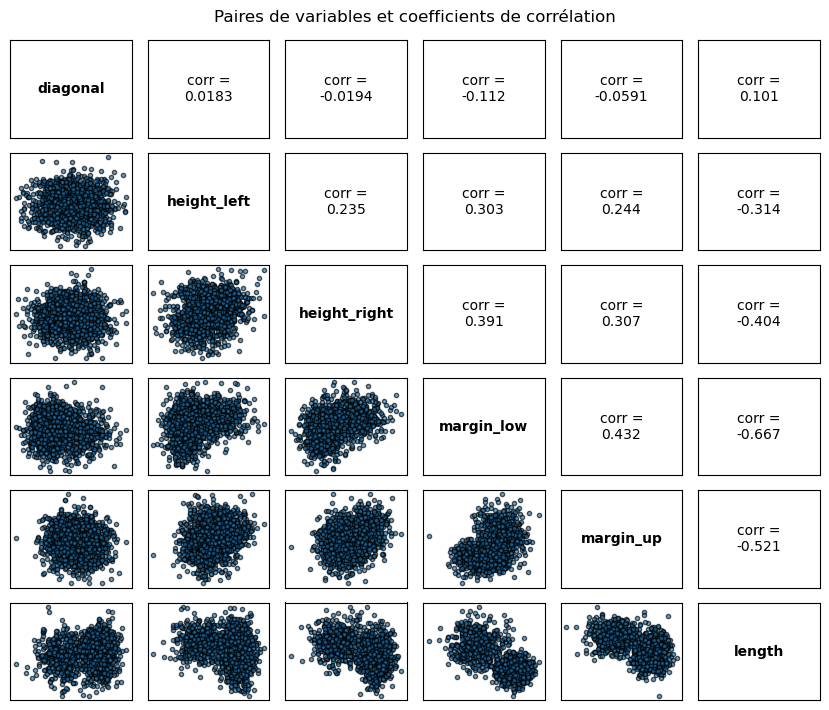

In [13]:
pairplot_correlation(df_billets_sans_na)

margin_low est plutôt bien corrélée avec les autres variables à l'exception de diagonal. Elle est particulièrement corrélée à length.

Plusieurs variables explicatives sont corrélées entre elles, il faut donc vérifier la pertinence de toutes les conserver grâce au test du F dont les hypothèses sont :

*H0 : il n'y a pas de relation significative entre la variable explicative et la variable dépendante si p-value > 5 % ;*<br>
*H1 : il y a une relation significative entre la variable explicative et la variable dépendante si p-value < 5 %.*

#### 2.3 Test de fisher et p-value

In [14]:
res = f_regression(X, y)
for column, result in zip(X.columns, res[1]):
    print(f'{column} : \t{result:>10.4g}')

del res, column, result

diagonal : 	 1.905e-05
height_left : 	 2.289e-32
height_right : 	 1.159e-54
margin_up : 	 1.922e-67
length : 	8.976e-189


*Pour chaque variable H0 est rejetée, on les conserve toutes.*

#### 2.4 Mise en place  du modèle

Avant d'effectuer la régression, Les données sont séparées en :

une partie « train » sur laquelle sera entraîné le modèle ;<br>
une partie « test » pour tester les résultats du modèle.

In [15]:
# Sépare les données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [16]:
# Effectue la régression
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

# Affiche l'intercept et les coefficients
print(f'intercept : \t{lr.intercept_:>6.3f}')
for column, lr_coeff in zip(X.columns, lr.coef_):
    print(f'{column} : \t{lr_coeff:>6.3f}')

del column, lr_coeff

intercept : 	19.510
diagonal : 	-0.072
height_left : 	 0.187
height_right : 	 0.234
margin_up : 	 0.266
length : 	-0.420


#### 2.5 Evaluation du modèle

*Pour évaluer le modèle, on l'applique aux données « test » puis on calcule une série d'indicateurs.*

In [18]:
# Effectue la prédiction sur les données test
y_pred = lr.predict(X_test)

# Calcule et affiche les métriques
lr_metrics = ['r2', 'mse', 'rmse', 'mae']


# Calcule les métriques
r2 = lr.score(X_train, y_train)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred)

# Stocke les métriques dans une liste
lr_metrics_values = []
lr_metrics_values.extend([r2, mse, rmse, mae])

# Affiche les métriques
lr_metrics = ['r2', 'mse', 'rmse', 'mae']

for lr_metric, lr_metric_value in zip(lr_metrics, lr_metrics_values):
    print(f'{lr_metric.upper()} : \t{lr_metric_value:.6f}')

del lr_metrics, lr_metrics_values, mse, rmse, mae, lr_metric, lr_metric_value

R2 : 	0.481499
MSE : 	0.232961
RMSE : 	0.482661
MAE : 	0.368762


*Le MAE ,MSE et RMSE sont des indicateurs qui nous permettent d'en savoir plus sur nos résidus. Plus l'indicateur est faible, meilleur est le modèle !*

#### 2.6 Interpretations des indicateurs


**1. Coefficient de détermination (R2)** 
mesure la proportion de la variance totale des variables dépendantes (cible) expliquée par le modèle.
dans notre étude il est égale a 0,481499 ce qui signifie que le modèle peut expliquer environ 48.15% de la variance observée dans les données. En d'autres termes, il capture partiellement la variance des données un R2 plus proche de 1 indiquerait une meilleure adéquation du modèle aux données.<br>

**2. Erreur quadratique moyenne (MSE - Mean Squared Error)**
Le MSE représente la moyenne des carrés des écarts entre les prédictions du modèle et les valeurs réelles. Notre  MSE est de 0.232961 signifie que, en moyenne, les prédictions du modèle sont écartées de 0.232961 unité carrée de la valeur réelle. Plus le MSE est faible, plus les prédictions du modèle sont précises par rapport aux valeurs réelles.<br>

**3. Erreur quadratique moyenne racine (RMSE - Root Mean Squared Error)**
Le RMSE est simplement la racine carrée du MSE. Il mesure la dispersion des résidus (erreurs de prédiction) du modèle.Notre RMSE est de 0.482661 indique que, en moyenne, les prédictions du modèle sont écartées de 0.482661 unité de la valeur réelle. Comme pour le MSE, un RMSE plus faible indique une meilleure précision du modèle.<br>
**4. Erreur absolue moyenne (MAE - Mean Absolute Error)**
Le MAE représente la moyenne des valeurs absolues des écarts entre les prédictions du modèle et les valeurs réelles. MAE = 0.368762 signifie que, en moyenne, les prédictions du modèle sont écartées de 0.368762 unité de la valeur réelle. Il est moins sensible aux valeurs aberrantes que le MSE.<br>

un R2 plus élevé et des valeurs plus faibles de MSE, RMSE et MAE indiquent une meilleure adéquation du modèle aux données, avec des prédictions plus précises et moins d'erreurs par rapport aux valeurs réelles.



**Le coefficient R² indique que le modèle explique moyennement la variance. A l'inverse, le carré moyen des erreurs (MSE) est plutôt proche de 0 ce qui est une bonne chose car c'est l'une des valeurs que l'on cherche à minimiser dans le cadre d'une régression.**

**Pour terminer l'analyse, on calule la valeur de R²ajusté qui est plus adapté au cas de la régression linéaire multiple. Il se calcule de la manière suivante :**

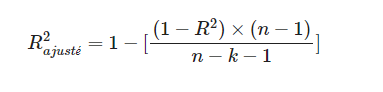<br>  : **n :le nombre d'observations** ;<br>
 : **k:le nombre de variables explicatives.**

In [19]:
# Calcule R² ajusté
n = len(y_test)
k = len(X_test.columns)
ajusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))

# Affiche la valeur de R² ajusté
print(f'R2 ajusté : {ajusted_r2:.6f}')

del n, k, r2, ajusted_r2

R2 ajusté : 0.476064


**R2 ajusté : 0.476064**<br>
**La valeur de R²ajusté est légèrement inférieure à la valeur de R².**

#### 2.7 Vérification des hypothèses

*Pour s'assurer de la fiabilité du modèle, il faut vérifier plusieurs hypothèses, notamment concernant les résidus qu'il faut donc calculer.*

In [20]:
# Calcule les résidus
residuals = y_test - y_pred

**Hypothèse 1 : linéarité du modèle**
*<br> La relation entre les variables explicatives et la variable cible doit être linéaire. Pour vérifier cela, on trace les résidus en fonction des valeurs prédites et on vérifie si on observe une relation linéaire.*

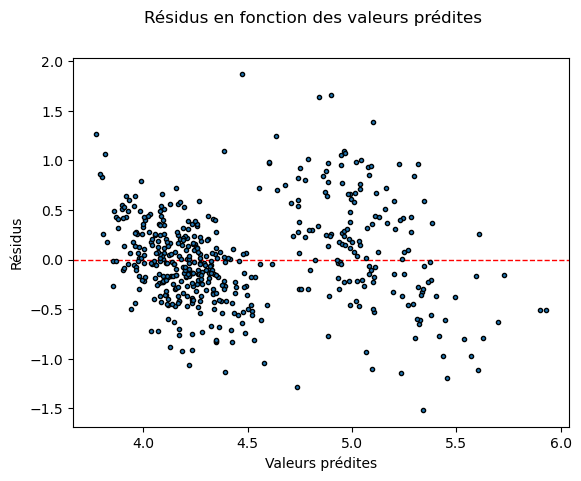

In [21]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=y_pred, y=residuals, marker='.', edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

*On n'observe pas de relation linéaire.*

**Hypothèse 2 : indépendance des résidus***<br> Les résidus ne doivent pas être liés c’est-à-dire que la valeur d’un résidu ne doit pas nous permettre de connaître celle d’un autre.* 



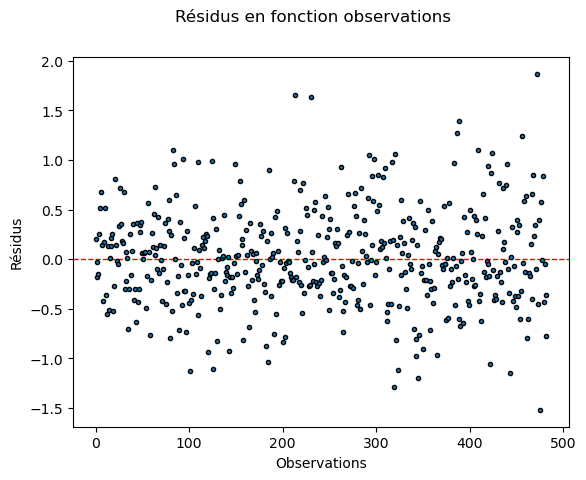

In [22]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=range(len(residuals)), y=residuals, marker='.',
           edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Observations')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction observations')

plt.show()

del fig, ax

**Les résidus semblent répartis de manière aléatoire autour de 0. Pour confimer notre observation, on réalise un test de Durbin-Watson. Cette statistique est comprise entre 0 et 4 :**<br>
*si sa valeur est proche de 0, il y a une autocorrélation positive ;*<br>
*si sa valeur est située autour de 2, il n'y a pas d’autocorrélation ;*<br>
*si sa valeur est proche de 4, il y a une autocorrélation négative.*


In [23]:
# Calcule et affichage du résultat du test de Durbin-Watson
res = durbin_watson(residuals)
print(f'Durbin-Watson : {res:.3f}')

del res

Durbin-Watson : 2.070


*La valeur est proche de 2, il y a donc indépendance des résidus.*

**Hypothèse 3 : homoscédasticité**


L'homoscédasticité significie que la variance des résidus est constante. Nous avons constaté précédemment que les résidus étaient dispersés de manière relativement uniforme autour de 0 donc nous pourrions considèrer que l'homoscédasticité est satisfaite. Néanmoins, nous allons réaliser le test statistique de Breush-Pagan dont les hypothèses sont les suivantes :

*H0 : l’homoscédasticité est présente si p-value > 5 %* ;<br>
*H1 : l’homoscédasticité n’est pas présente si p-value < 5 %.*

In [24]:
#test de Breush-Pagan
res = het_breuschpagan(residuals, X_test.assign(constant=1))
print(f'p-value : {res[1]:.3e}')

del res

p-value : 1.214e-05


*conformement aux observations, le test indique que l'homoscédasticité n'est pas présente.*

**Hypothèse 4 : normalité des résidus**

Les valeurs des résidus doivent suivre une loi normale. On trace la distribution des résidus.

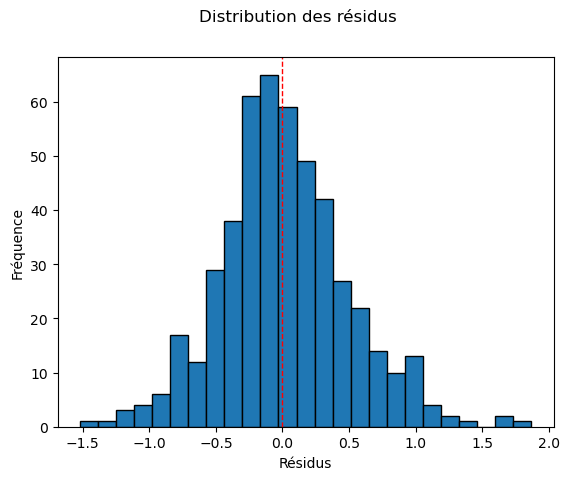

In [25]:
# graphique
fig, ax = plt.subplots()

ax.hist(x=residuals, bins=25, edgecolor='k')
ax.axvline(x=0, linestyle='--', linewidth=1, color='r')

ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
fig.suptitle('Distribution des résidus')

plt.show()

del fig, ax

**On observe un décalage sur la gauche mais, à priori, la distribution proche de la normalité. Nous allons réaliser un test de Shapiro-Wilk ayant les hypothèses suivantes :**

*H0 : La normalité est vérifiée si p-value > 5 % ;<br>*
*H1 : La normalité n'est pas vérifiée si p-value < 5 %.*

In [26]:
#  test de Shapiro-Wilk
res = stats.shapiro(residuals)
print(f'p-value : {res.pvalue:.3e}')

del res

p-value : 1.654e-03


*Là aussi, contrairement aux observations le test n'est pas concluant.*

**Hypothèse 5 : pas de colinéarité**
<br>
*Les variables explicatives ne doivent pas être fortement corrélées entre elles, or, nous avions observé quelques coefficients de corrélation assez élevés. Afin de déterminer si cette hypothèse est validée, nous allons calculer le « VIF » (facteur d'inflation de variance) pour chaque variable explicative :*

si VIF = 1 : pas de corrélation entre les variables explicatives ;<br>
si 1 < VIF ≤ 5 : il y a une corrélation modérée mais ne nécessite pas forcément une attention particulière ;<br>
si VIF > 5 : il y a une corrélation importante qui peut nuire au résultat de la régression.

Le VIF se calcule de la manière suivante :

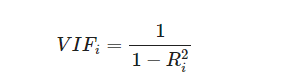



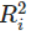 valeur de
[image-2.png](attachment:image-2.png) de la regression pour chaque variable explicative considérée comme dépendante.

In [27]:
# Calcule le VIF pour chaque variable explicative considérée dépendante
for column in X_train.columns:
    y_vif = X_train[column]
    X_vif = X_train.drop(columns=column)
    lr_vif = LinearRegression().fit(X_vif, y_vif)
    r2_vif = lr_vif.score(X_vif, y_vif)
    vif = 1 / (1 - r2_vif)
    print(f'{column} : \t{vif:.3f}')

del column, y_vif, X_vif, lr_vif, r2_vif, vif

diagonal : 	1.006
height_left : 	1.167
height_right : 	1.206
margin_up : 	1.451
length : 	1.597


*Toutes les valeurs sont proches de 1, il n'y a donc pas de problème de colinéarité.*

#### 2.8 Prédiction des valeurs manquantes

Grâce au modèle mis en place, on prédit les valeurs manquantes des enregistrements incomplets puis on reconstitue le jeu de données complet.

In [28]:
# Copie  enregistrements contenant les valeurs manquantes
df_billets_na = df_billets[df_billets.isna().any(axis='columns')].copy()

# Prédit les valeurs manquantes grâce au modèle
df_billets_na['margin_low'] = lr.predict(
    df_billets_na.drop(columns=['is_genuine', 'margin_low']))

# Concatène les enregistrements avec et sans valeurs manquantes
df_billets = pd.concat([df_billets_sans_na, df_billets_na]).sort_index()

del (df_billets_sans_na, df_billets_na, X, y, X_train, y_train, X_test,
     y_test, y_pred, lr, residuals)

## 3. Analyse descriptive

#### 3.1 Analyse Univariée

In [29]:
# Affiche un aperçu des données
df_billets.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
683,True,172.59,104.22,104.01,4.47,2.95,113.19
256,True,171.85,103.65,103.55,4.48,3.31,112.89
12,True,171.89,103.89,103.40,4.11,2.96,113.24
782,True,172.25,104.02,104.16,3.87,3.16,113.77
219,True,172.11,103.33,103.80,4.55,2.91,113.17


In [30]:
# Affiche un résumé du DataFrame
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


**Il n'y a plus de valeurs manquantes**

In [31]:
# Affiche une description synthétique des données numériques
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483320,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659744,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Les données semblent plutôt homogènes :<br>

les moyennes et les médianes sont proches ;<br>
les valeurs minimales et maximales sont proches des moyennes.

In [32]:
# Affichez le nombre de vrais/faux billets
df_billets['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

Le jeu de données comprend 2/3 de billets authentiques et 1/3 de faux billets.

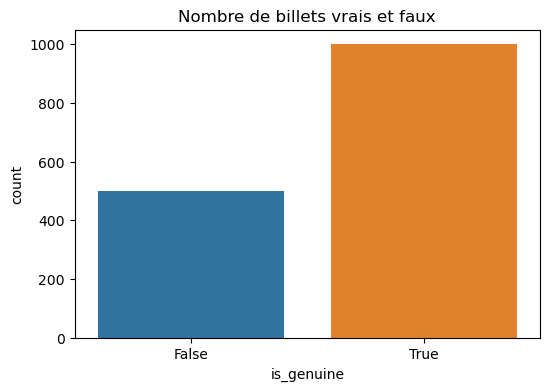

In [33]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_billets, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
plt.show()

In [34]:
# Affiche la moyenne et la médiane des variables pour les vrais et faux billets
df_billets.groupby('is_genuine').agg({'mean', 'median'}).round(3).stack()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                      
False      median   171.910      104.180       104.160       5.180      3.350   
           mean     171.901      104.190       104.144       5.214      3.350   
True       median   171.990      103.950       103.810       4.120      3.050   
           mean     171.987      103.949       103.809       4.118      3.052   

                    length  
is_genuine                  
False      median  111.630  
           mean    111.631  
True       median  113.205  
           mean    113.202

Pour chaque variable les moyennes et les médianes sont proches. margin_low est la variable dont la moyenne et la médiane diffèrent le plus en fonction de l'authenticité des billets. Traçons la dispersion et la distribution des variables.

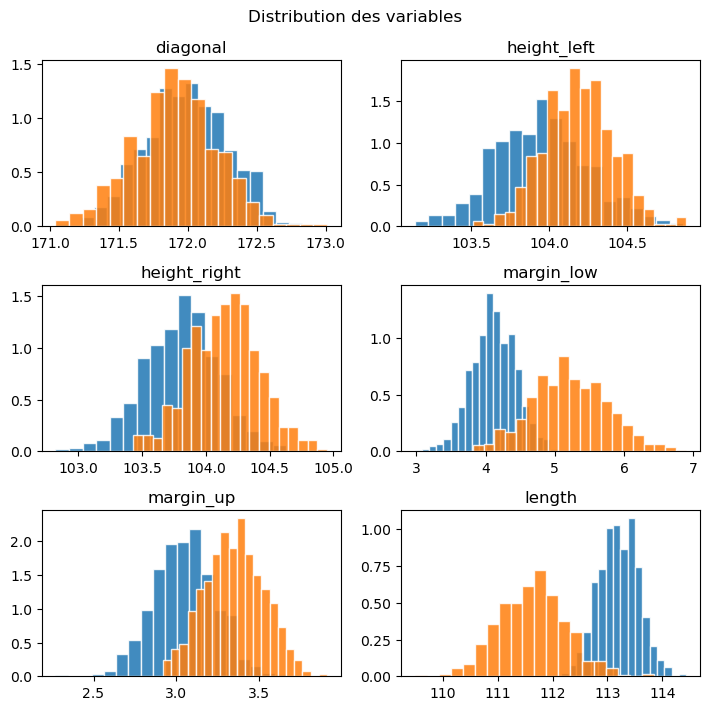

In [35]:
# Liste les valeurs de 'is_genuine'
is_genuine_values = df_billets['is_genuine'].unique()

# Trace les histogrammes de chaque variable
fig, axs = plt.subplots(3, 2, figsize=(7.2, 7.2))
axs = axs.flatten()

for i, column in enumerate(df_billets.columns[1:]):
    for j, is_genuine_value in enumerate(is_genuine_values):
        axs[i].hist(df_billets.loc[df_billets['is_genuine'] == is_genuine_value, column], alpha=0.85, bins=20, edgecolor='w', density=True)
        axs[i].set_title(column)

fig.suptitle('Distribution des variables')

fig.tight_layout()

plt.show()

del is_genuine_values, fig, axs, i, column, j, is_genuine_value

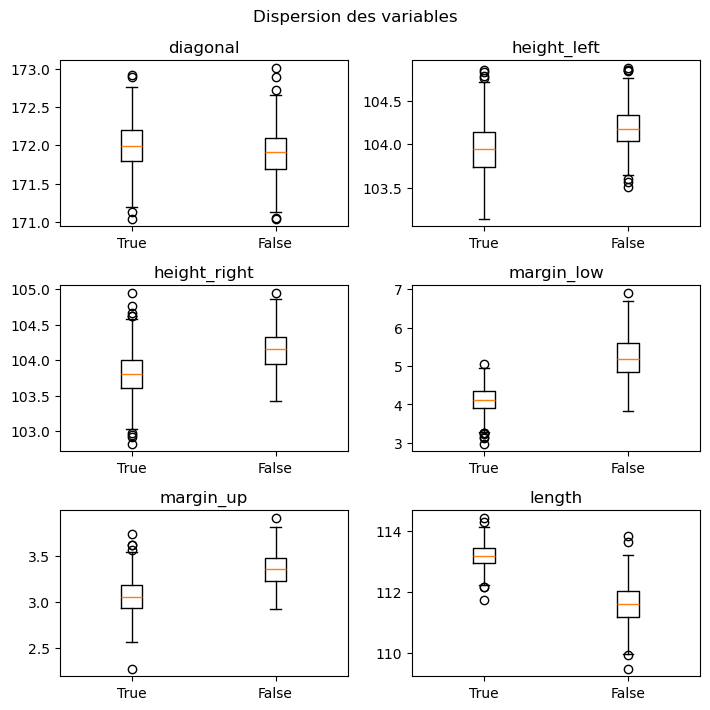

In [36]:
# Liste les valeurs de 'is_genuine'
is_genuine_values = df_billets['is_genuine'].unique()

# Trace les boxplots de chaque variable
fig, axs = plt.subplots(3, 2, figsize=(7.2, 7.2))
axs = axs.flatten()

for i, column in enumerate(df_billets.columns[1:]):
    for j, is_genuine_value in enumerate(is_genuine_values):
        axs[i].boxplot(df_billets.loc[df_billets['is_genuine'] == is_genuine_value, column], positions=[j])
        axs[i].set_title(column)
        
    axs[i].set_xticklabels(is_genuine_values)

fig.suptitle('Dispersion des variables')

fig.tight_layout()

plt.show()

del is_genuine_values, fig, axs, i, column, j, is_genuine_value

Les différences dimensionnelles entre les vrais et les faux billets sont plus visibles : diagonal est assez similaire tandis que margin_low et length sont très différentes. Nous allons afficher les paires de variables mais en les différenciant en fonction de l'authenticité.

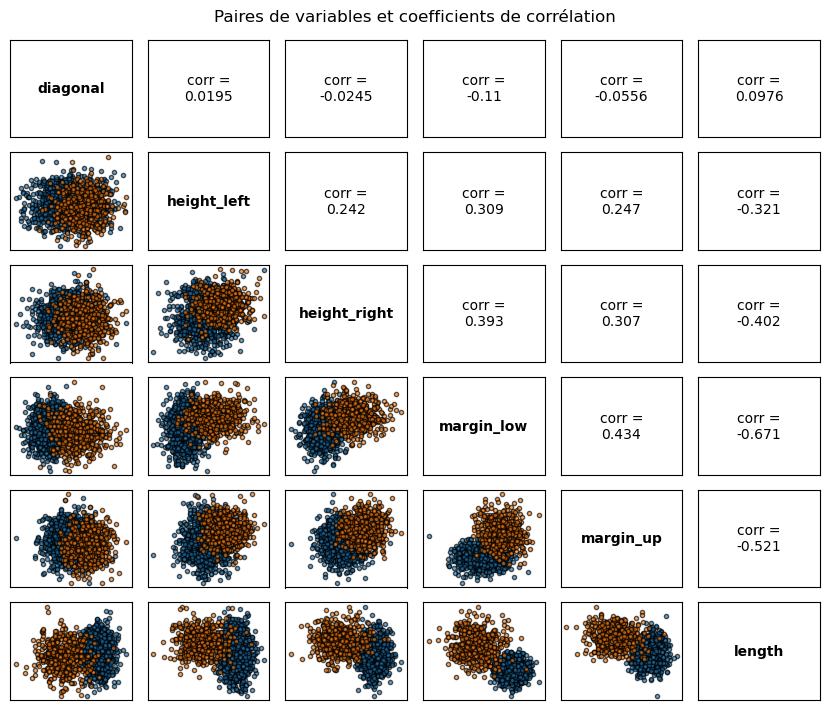

In [37]:
# Trace les variables quantitatives par paires
pairplot_correlation(df_billets, hue='is_genuine')

On visualise assez bien deux groupes distincts, notamment pour les variables les plus corrélées entre elles.

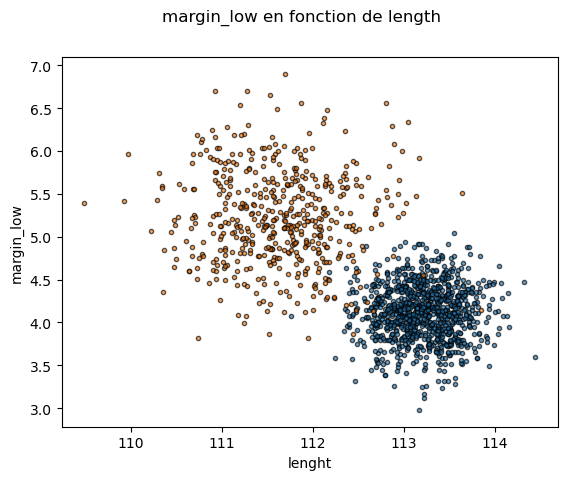

In [38]:
# Trace 'margin_low' et 'length'
fig, ax = plt.subplots()

ax.scatter(data=df_billets[df_billets['is_genuine'] == True],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)
ax.scatter(data=df_billets[df_billets['is_genuine'] == False],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)

ax.set_xlabel('lenght')
ax.set_ylabel('margin_low')

fig.suptitle('margin_low en fonction de length')

plt.show()

del fig, ax

Pour finir, on affiche la matrice de corrélation en incluant is_genuine.

Les variables les plus corrélées à is_genuine sont celles qui sont les plus corrélées entre elles. On peut supposer que ces variables joueront un rôle déterminant dans l'algorithme de détection.

## 4. Contruction de l'algorithme de detection

#### 4.1 Pretraitement

L'algorithme doit détecter les faux billets, or la variable dont nous disposons est is_genuine. Cela signifie que quand sa valeur est vraie, le billet est authentique. Par choix, nous allons préférer que notre variable cible soit vraie lorsqu'un faux billet est détecté. De plus, nous allons la convertir en valeur numérique.

In [39]:
# Tranforme 'is_genuine' en 'is_fake' avec des valeurs numériques
df_billets = df_billets.rename(columns={'is_genuine': 'is_fake'})
df_billets['is_fake'] = df_billets['is_fake'].map({True: 0, False: 1})

df_billets.head(3)

,is_fake,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.52,2.89,112.83
1,0,171.46,103.36,103.66,3.77,2.99,113.09
2,0,172.69,104.48,103.50,4.40,2.94,113.16


Puis on définit les variables et la cible et on sépare les données en entrainement et en test.

In [40]:
# Définit X et y
X = df_billets.drop(columns='is_fake')
y = df_billets['is_fake']

# Sépare les données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Pour comparer les résultats des différentes méthodes de classification, nous définissons une fonction qui va sauvegarder les métriques.

In [41]:
def save_classifier_metrics(y_true, y_pred, clf_label, pos_label):
    '''Sauvegarde et affiche les métriques dans un dictionnaire.
    Paramètres :
    - y_true : la vraie valeur des labels
    - y_pred : les labels prédits par la méthode de classification
    - clf_label : le nom de la méthode de classification
    - pos_label : le label de la classe positive
    '''

    if not('clf_metrics_dict' in globals()):  
        global clf_metrics_dict
        clf_metrics_dict = {
            'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}
        
    clf_metrics_dict['accuracy'].update(
        {clf_label: metrics.accuracy_score(y_true, y_pred)})
    
    clf_metrics_dict['precision'].update(
        {clf_label: metrics.precision_score(
            y_true, y_pred, pos_label=pos_label)}
    )
    
    clf_metrics_dict['recall'].update(
        {clf_label: metrics.recall_score(
            y_true, y_pred, pos_label=pos_label)}
    )
    
    clf_metrics_dict['f1-score'].update(
        {clf_label: metrics.f1_score(
            y_true, y_pred, pos_label=pos_label)}
    )

    return pd.DataFrame(clf_metrics_dict)

**Méthode 1 : Régression logistique**

La régression logistique est une méthode de classification supervisée dont l'objectif est de modéliser les relations entre une variable binaire en fonction de variables généralement quantitatives. Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien.

**Régression sans optimisation**

In [42]:
# Effectue la régression
clf_log_reg = LogisticRegression()
clf_log_reg.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_log_reg.predict(X_test)

# Affiche les coefficients de la régression
for column, coef in zip(X.columns, clf_log_reg.coef_[0]):
    print(f'{column} : \t{coef:>9.6f}')

del column, coef
# toujours affiche les pv valeurs au coeff pour voir ce qui est significatif ou pas

diagonal : 	 0.159883
height_left : 	 1.605045
height_right : 	 1.880435
margin_low : 	 3.188571
margin_up : 	 2.778681
length : 	-3.679474


In [43]:

# Sépare les données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Fit du modèle de régression logistique avec sklearn
clf_log_reg = LogisticRegression()
clf_log_reg.fit(X_train, y_train)

# Ajout des p-valeurs en utilisant statsmodels
X_train_sm = sm.add_constant(X_train)  # Ajoute une constante pour l'intercept
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Récupérer les coefficients et les p-valeurs
coefficients = np.append(clf_log_reg.intercept_, clf_log_reg.coef_[0])
p_values = result.pvalues

# Créer un DataFrame pour les résultats
results_table = pd.DataFrame({
    'Coefficients': coefficients,
    'p-values': p_values
}, index=['Intercept'] + X.columns.tolist())

# Afficher le tableau
print(results_table)

Optimization terminated successfully.
         Current function value: 0.033304
         Iterations 13
              Coefficients      p-values
Intercept         0.015411           NaN
diagonal          0.159883  5.875420e-01
height_left       1.605045  6.144718e-02
height_right      1.880435  2.965281e-02
margin_low        3.188571  3.673982e-07
margin_up         2.778681  7.015506e-05
length           -3.679474  3.754665e-09


*L'analyse des coefficients donne des résultats cohérents avec le nuage de points tracé à la fin de la partie précédente avec length et margin_low. Plus les billets sont longs, plus ils sont authentiques, et plus leur marge basse est grande, plus ils sont faux.*

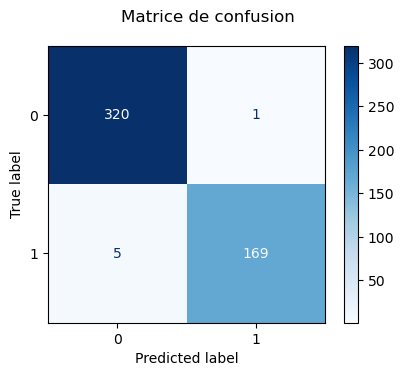

In [44]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

La matrice de confusion permet de décrire les performances du modèle :

**Les vrais positifs** : pour 169 billets, nous avons correctement prédit qu'ils sont faux.<br>
**Les vrais négatifs** : pour 320 billets, nous avons correctement prédit qu'ils sont authentiques.<br>
**Les faux positifs** : pour 1 billet, nous avons prédit à tort qu'il n'est pas authentiques.<br>
**Les faux négatifs** : pour 5 billets, nous avons prédit à tort qu'ils sont authentique.<br>
A partir de la mtatrice, il est possible de calculer différents métriques intégrés dans le module sklearn.metrics.

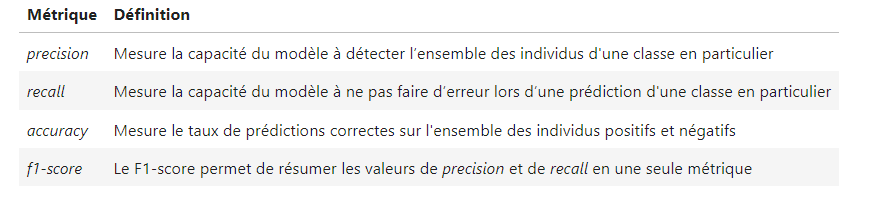

**Il est important que l'algorithme soit plus précis sur la détection des faux billets que sur celle des vrais billets : il est moins problématique de détecter un billet authentique comme étant faux que l'inverse. Ce sont donc les métriques des faux billets que nous souhaitons conserver.**

In [45]:
save_classifier_metrics(y_test, y_pred, 'logistic regression', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558


In [46]:
del y_pred

**Optimisation avec GridSearchCV**

Essayons d'améliorer notre modèle en optimisant le choix des paramètres de la régression grâce à GridSearchCV. Nous n'allons pas changer le solver qui est adapté à la taille et à la complexité du jeu de données et nous laissons donc penalty=l2. Seul C va finalement varier. Ce paramètre agit sur la manière dont penalty va essayer de réduire l'overfitting.

GridSearchCV effectue également une validation croisée qui exécute le processus de modélisation sur différents sous-ensembles de données afin d'obtenir plusieurs mesures de la qualité du modèle et ainsi s'assurer de sa qualité.

In [47]:
# Crée le 'f1-score' des faux billets comme métrique
scoring = metrics.make_scorer(metrics.f1_score, pos_label=1)

# Définit les paramètres et valeurs à tester
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}

# Exécute GridSearchCV avec la régression logistique
clf_log_reg_gs = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5
)
clf_log_reg_gs.fit(X_train, y_train)

# Affiche le meilleur paramètre
print(clf_log_reg_gs.best_params_)

del param_grid

{'C': 100}


La valeur optimale serait donc **C=100.** Refaisons la regression logistique avec ce paramètre.

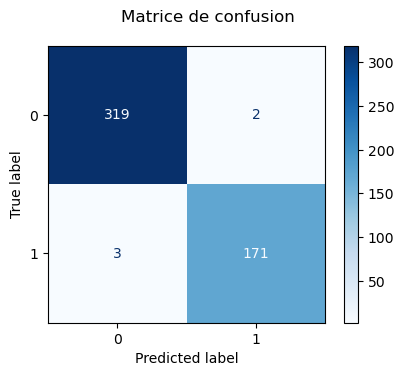

In [48]:
# Effectue la régression avec C=100
clf_log_reg_gs = LogisticRegression(C=100, max_iter=100)
clf_log_reg_gs.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_log_reg_gs.predict(X_test)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [49]:
save_classifier_metrics(y_test, y_pred, 'logistic regression + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591


In [50]:
del y_pred

**Méthode 2 : k-means**

k-means sans optimisation

La classification k-means est un algorithme non supervisé principalement utilisé pour le clustering. Dans le cadre de notre analyse, nous allons à priori avoir seulement deux clusters (vrais et faux billets). En cherchant à savoir à quel groupe appartient un billet, nous pourrons donc prédire sa classe.

La première étape consiste à normaliser les données d'entraînement.

In [51]:
# Standardise les données test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Pour confirmer que seuls deux clusters sont nécessaires, nous allons utiliser la méthode du coude et celle du score de Silhouette.

C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

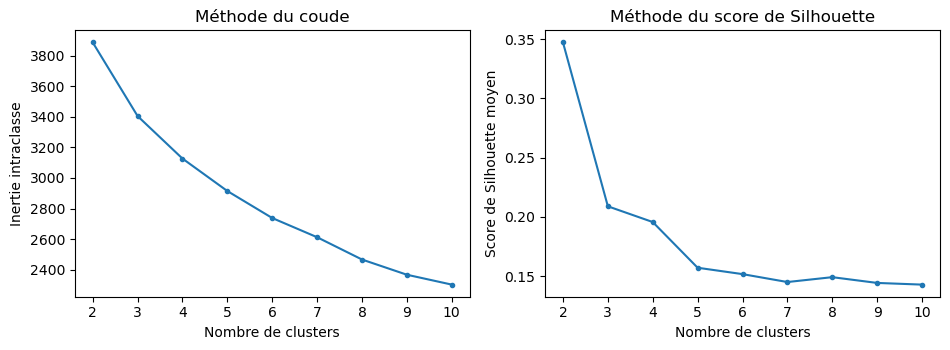

In [52]:
# Initialise les variables
n_clusters_range = range(2, 11)
inertias=[]
silhouette_avg_scores = []

# Calcul l'inertie et les score de silhouette moyen pour chaque valeur
# du nombre de clusters
for n_clusters in n_clusters_range:
    clustering = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++')
    clustering = clustering.fit(X_train_scaled)
    
    inertias.append(clustering.inertia_)

    silhouette_avg = metrics.silhouette_score(
        X_train_scaled, clustering.labels_)
    silhouette_avg_scores.append(silhouette_avg)

# Trace les graphiques
fig, axs = plt.subplots(1, 2, figsize=(9.6, 3.6))

axs[0].plot(n_clusters_range, inertias, marker='.')
axs[1].plot(n_clusters_range, silhouette_avg_scores, marker='.')

# Définie la position des graduations
axs[0].xaxis.set_major_locator(ticker.IndexLocator(1, 0))
axs[1].xaxis.set_major_locator(ticker.IndexLocator(1, 0))
# Définie les titres des graphiques et de leurs axes
axs[0].set_xlabel('Nombre de clusters')
axs[0].set_ylabel('Inertie intraclasse')
axs[0].set_title('Méthode du coude')
axs[1].set_xlabel('Nombre de clusters')
axs[1].set_ylabel('Score de Silhouette moyen')
axs[1].set_title('Méthode du score de Silhouette')

fig.tight_layout()

plt.show()

del (n_clusters_range, inertias, silhouette_avg, silhouette_avg_scores,
     n_clusters, clustering, fig, axs)

La méthode du coude ne permet pas de définir facilement le nombre de clusters optimal car on n'observe pas de point à partir duquel l'inertie évolue de manière linéaire.

C'est pour deux clusters que le score de Silhouette moyen est le meilleur, mais cela est souvent le cas. Le score diminue au fûr et à mesure que le nombre de clusters augmente, il n'y a donc pas de raison de choisir plus de groupes que deux.

In [53]:
# Effectue le clustering avec 2 clusters
clf_kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10,
                    random_state=42)
clf_kmeans.fit(X_train_scaled)

C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=2, n_init=10, random_state=42)

On normalise les données à tester avant de faire la prédiction, mais attention, on applique uniquement la méthode transform sans fit contrairement à ce que nous avions fait pour les données d'entraînement.

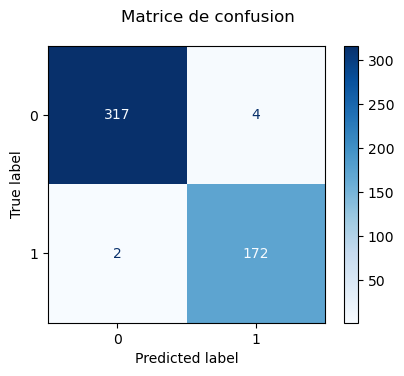

In [54]:
# Normalise les données test
X_test_scaled = scaler.transform(X_test)

# Effectue la prédiction sur les données test
y_pred = clf_kmeans.predict(X_test_scaled)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

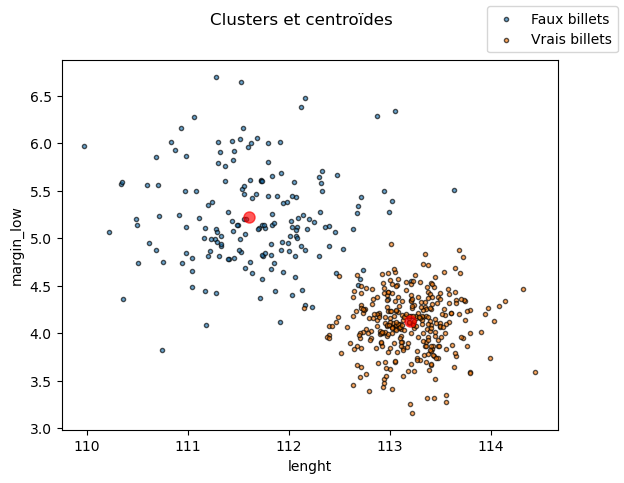

In [55]:
# Trace les clusters et leur centroïde avec 'margin_low' et 'length'
df_temp = X_test.copy()
df_temp['cluster'] = y_pred

fig, ax = plt.subplots()

ax.scatter(data=df_temp[df_temp['cluster'] == 1],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)
ax.scatter(data=df_temp[df_temp['cluster'] == 0],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)

ax.plot(scaler.inverse_transform(clf_kmeans.cluster_centers_)[1][5],
        scaler.inverse_transform(clf_kmeans.cluster_centers_)[1][3],
        marker='o', markersize=8, color='r', alpha=0.65)

ax.plot(scaler.inverse_transform(clf_kmeans.cluster_centers_)[0][5],
        scaler.inverse_transform(clf_kmeans.cluster_centers_)[0][3],
        marker='o', markersize=8, color='r', alpha=0.65)

ax.set_xlabel('lenght')
ax.set_ylabel('margin_low')

fig.suptitle('Clusters et centroïdes')

fig.legend(['Faux billets', 'Vrais billets'])

plt.show()

del fig, ax, df_temp

In [56]:
save_classifier_metrics(y_test, y_pred, 'k-means', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857


In [57]:
del y_pred

**Validation croisée cross_validate**

On vérifie la qualité de la classification k-means grâce à la validation croisée.

In [58]:
# Standardise les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Calcul 'accuracy' pour 5 'folds'
scores = cross_val_score(
    KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42),
    X_train_scaled, y_train, cv=5, scoring=scoring
)

# Affiche les résulatats
print(
    f'f1-score_fake\n'
    f'min. :\t{np.min(scores):.6f}\n'
    f'max. :\t{np.max(scores):.6f}\n'
    f'moy. :\t{np.average(scores):.6f}'
)

del scores

C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

f1-score_fake
min. :	0.958678
max. :	0.983333
moy. :	0.973659


C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


*Les résultats montrent que la qualité du modèle varie en fonction des données, on peut donc mettre en doute sa qualité.*

In [59]:
del scaler, X_train_scaled, X_test_scaled

**Méthode 3 : k-nearest neighbors (kNN)**

L'algorithme KNN (K-nearest neighbors) est une méthode supervisé utilisé pour la régression ou la classification. Il se base sur la distance entre observations voisines.

**kNN sans optimisation**

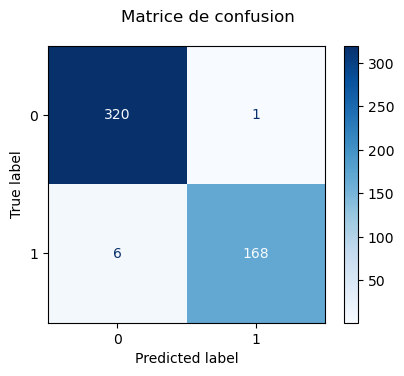

In [60]:
# Standardise les données test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Effectue les kNN
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train_scaled, y_train)

# Normalise les données test
X_test_scaled = scaler.transform(X_test)

# Effectue la prédiction sur les données test
y_pred = clf_knn.predict(X_test_scaled)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [61]:
save_classifier_metrics(y_test, y_pred, 'knn', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592


In [62]:
del y_pred

**Optimisation avec GridSearchCV**

On utilise GridSearchCV pour chercher les meilleurs paramètres.

In [64]:
# Définit les paramètres et valeurs à tester
param_grid = {
    'n_neighbors' : np.arange(1, 100, 3)
}

# Exécute GridSearchCV avec kNN
clf_knn_gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid, scoring=scoring, cv=5)
clf_knn_gs.fit(X_train_scaled, y_train)

# Affiche le meilleur paramètre
print(clf_knn_gs.best_params_)

del param_grid

{'n_neighbors': 7}


Puis on relance l'algorithme avec ces nouveaux paramètres.

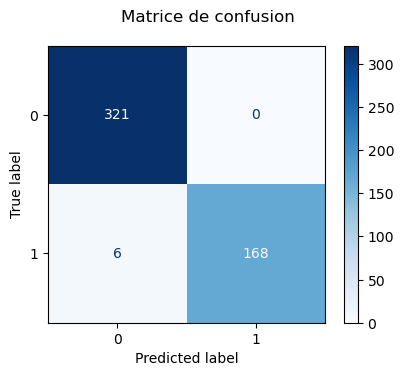

In [65]:
# Effectue les kNN
clf_knn_gs = KNeighborsClassifier(n_neighbors=7)
clf_knn_gs.fit(X_train_scaled, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_knn_gs.predict(X_test_scaled)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [66]:
save_classifier_metrics(y_test, y_pred, 'knn + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456


In [67]:
del y_pred, scaler, X_train_scaled, X_test_scaled

**Méthode 4 : arbre de décision**

L'arbre de décision est une méthode d'apprentissage supervisé utilisée pour la classification et la régression. L'objectif est de créer un modèle qui prédit la valeur d'une variable cible en apprenant des règles de décision simples déduites des caractéristiques des données. Une série de décisions séquentielles (« si-alors ») sont prises en fonction des caractéristiques des données créant ainsi une structure en arboresence.

**Arbre sans optimisation**

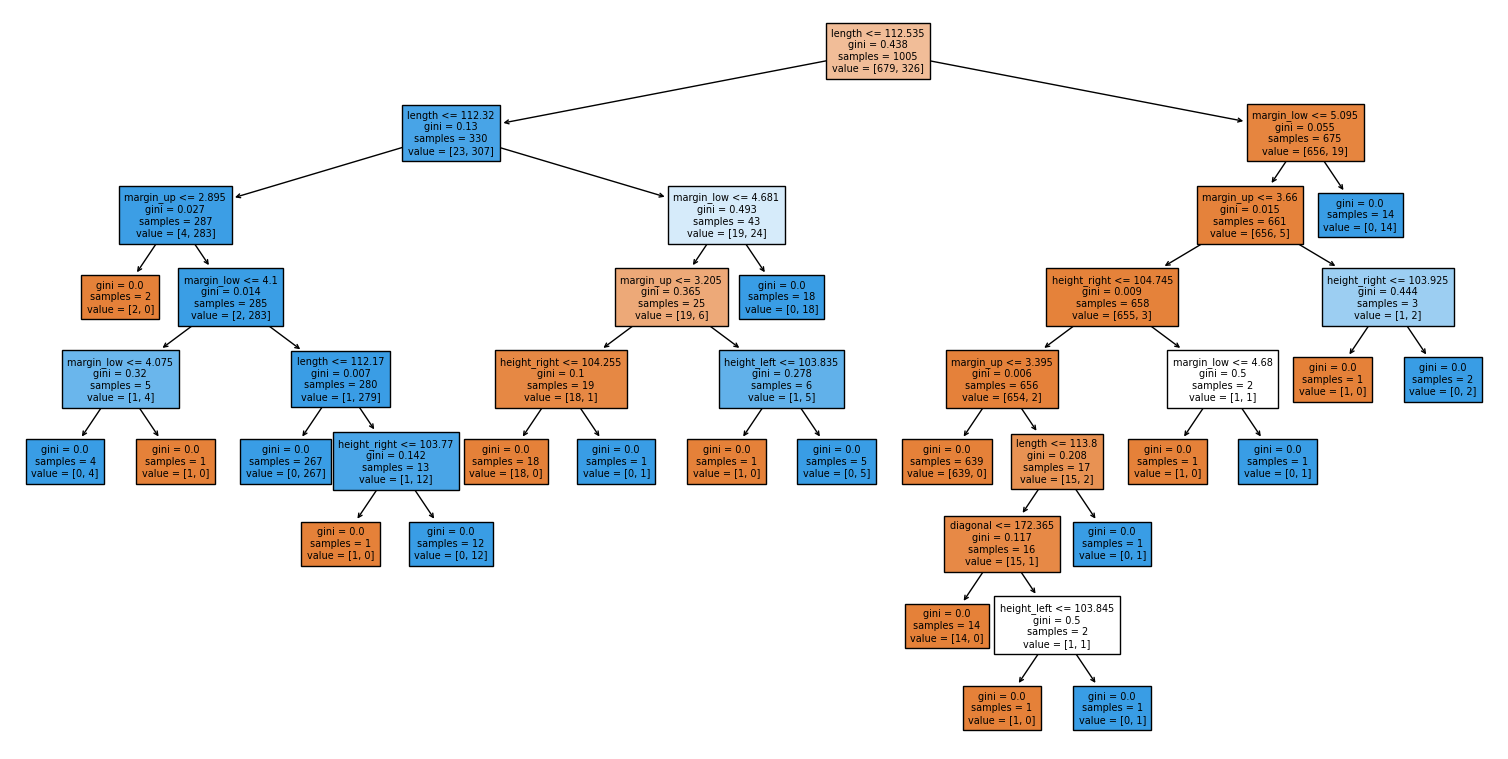

In [68]:
# Effectue l'arbre de décision
clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_tree.predict(X_test)

# Affiche l'arbre
fig, ax = plt.subplots(figsize=(19.2, 9.6))
plot_tree(clf_tree, feature_names=X.columns, filled=True, fontsize=7, ax=ax)
plt.show()

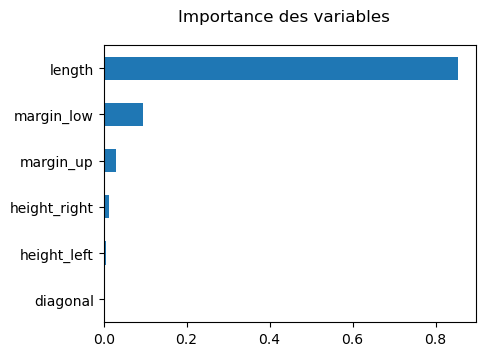

In [69]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_tree.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

Le graphique correspond bien à l'analyse descriptive où notamment diagonal était très proche pour les vrais et les faux billets. Il est donc logique que sont importance soit assez faible dans la prise de décision.

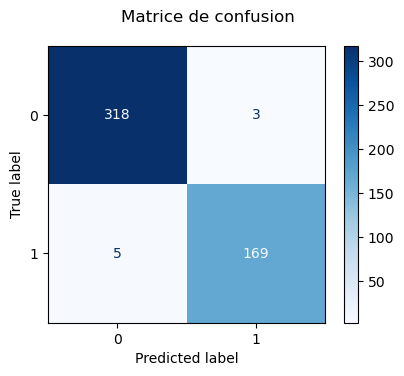

In [70]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [71]:
save_classifier_metrics(y_test, y_pred, 'decision tree', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879


In [72]:
del y_pred

**Optimisation avec GridSearchCV**

On utilise GridSearchCV pour chercher les meilleurs paramètres.

In [73]:
# Définit les paramètres et valeurs à tester
param_grid = {
    'max_depth' : np.arange(start=1, stop=10, step=1),
    'min_samples_leaf' : np.arange(start=5, stop=250, step=50),
    'min_samples_split' : np.arange(start=10, stop=500, step=50)
}

# Exécute GridSearchCV avec l'arbre de décision
clf_tree_gs = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5)
clf_tree_gs.fit(X_train, y_train)

# Affiche le meilleur paramètre
print(clf_tree_gs.best_params_)

del param_grid

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10}


Puis on effectue la classification avec ces nouveaux paramètres.

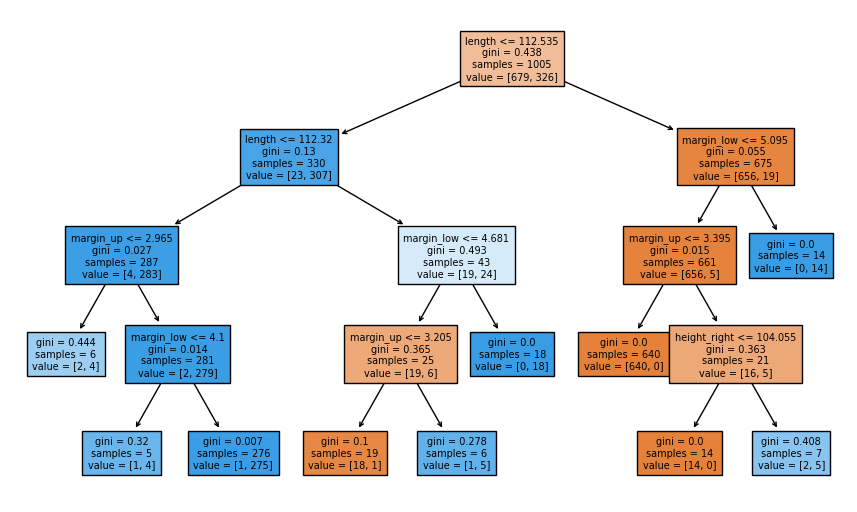

In [74]:
# Effectue l'arbre de décision
clf_tree_gs = DecisionTreeClassifier(
    max_depth=4, min_samples_leaf=5, min_samples_split=10)
clf_tree_gs.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_tree_gs.predict(X_test)

# Affiche l'arbre
fig, ax = plt.subplots(figsize=(10.8, 6.4))
plot_tree(clf_tree_gs, feature_names=X.columns, filled=True, fontsize=7, ax=ax)
plt.show()

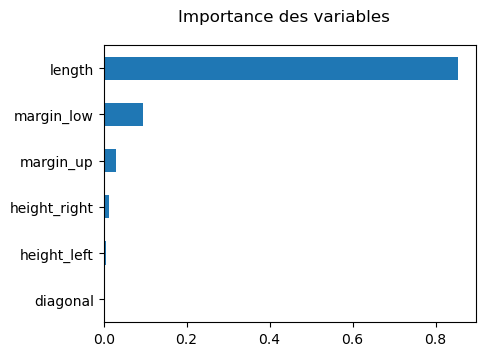

In [75]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_tree.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

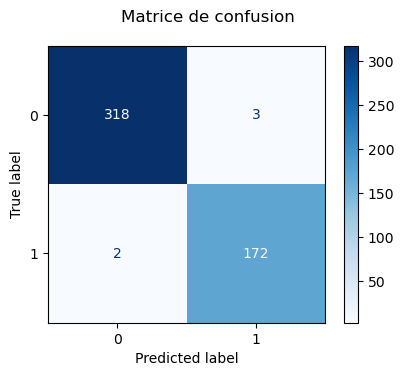

In [76]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [77]:
save_classifier_metrics(y_test, y_pred, 'decision tree + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673


In [78]:
del y_pred

**Méthode 5 : forêt aléatoire**

La forêt aléatoire est un algorithme d’apprentissage supervisé qui compile de résultat de plusieurs arbres de décision formés de manière alétaoire.

**Forêt sans optimisation**

In [79]:
# Effectue la forêt aléatoire
clf_forest = RandomForestClassifier(max_depth=2, random_state=0)
clf_forest.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_forest.predict(X_test)

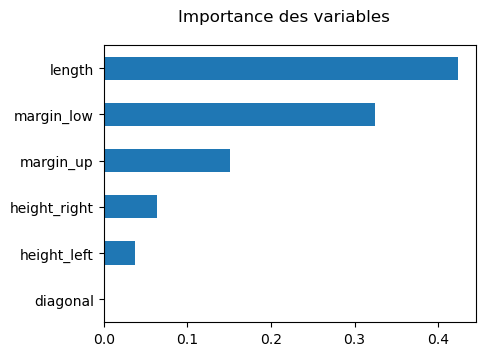

In [80]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_forest.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

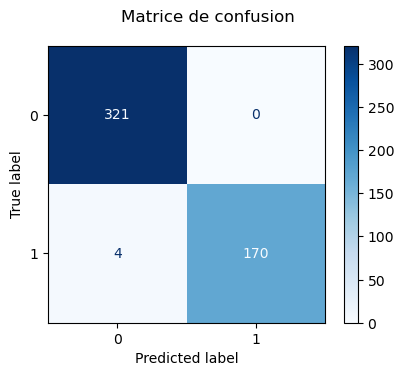

In [81]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [82]:
save_classifier_metrics(y_test, y_pred, 'random forest', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372


In [83]:
del y_pred

**Optimisation avec GridSearchCV**

In [84]:
# Définit les paramètres et valeurs à tester
param_grid = {
    'n_estimators': np.arange(start=1, stop=6, step=1),
    'max_depth': np.arange(start=1, stop=6, step=1),
    'min_samples_leaf': np.arange(start=5, stop=50, step=10),
    'min_samples_split': np.arange(start=10, stop=100, step=50)
}

# Exécute GridSearchCV avec l'arbre de décision
clf_forest_gs = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5)
clf_forest_gs.fit(X_train, y_train)

# Affiche le meilleur paramètre
print(clf_forest_gs.best_params_)

del param_grid

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 5}


In [85]:
# Effectue la forêt aléatoire
clf_forest_gs = RandomForestClassifier(
    n_estimators=5, max_depth=4, min_samples_leaf=5, min_samples_split=10,
    random_state=0
)
clf_forest_gs.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_forest_gs.predict(X_test)

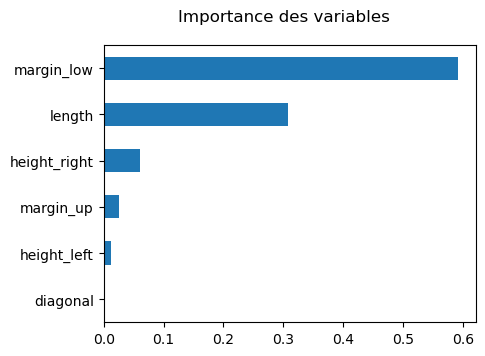

In [86]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_forest_gs.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

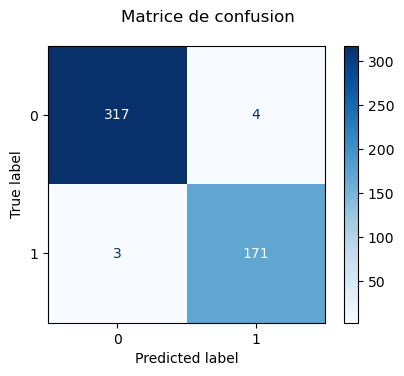

In [87]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [88]:
save_classifier_metrics(y_test, y_pred, 'random forest + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943


In [89]:
del y_pred

**Méthode 6 : Bagging**

Le bagging est un méta-algorithme faisant partie des méthodes ensemblistes pouvant être utilisé en régression comme en classification. Il utilise de multiples fois un algorithme pour obtenir un résultat plus fiable en réalisant un échantillonnage des données et en l'entraînant de façon séparée sur chacun de ces échantillons. Il assemble ensuite les résultats des modèles obtenus.

In [90]:
# Effectue le baggin avec l'arbre de décision
clf_bagging = BaggingClassifier(
    DecisionTreeClassifier(
        max_depth=4, min_samples_leaf=5, min_samples_split=10),
        n_estimators=50, random_state=0
)
clf_bagging.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_bagging.predict(X_test)

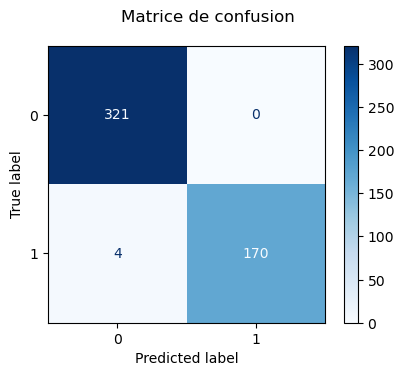

In [91]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [92]:
save_classifier_metrics(y_test, y_pred, 'bagging', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [93]:
del y_pred

**Méthode 7 : Boosting**

Le boosting se base sur le même principe que le bagging sans la dimension aléatoire. Il tient du résultat d'un modèle et surtout de ses erreurs pour améliorer les performances en formant un nouveau modèle qui réussisse à prédire les erreurs faites par le modèle original.

In [94]:
# Effectue le Boosting
clf_boosting = GradientBoostingClassifier(
    max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50,
    random_state=0
)
clf_boosting.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_boosting.predict(X_test)

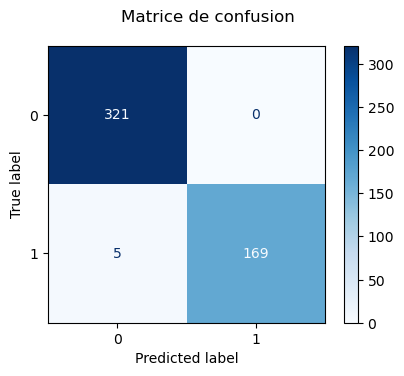

In [95]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [96]:
save_classifier_metrics(y_test, y_pred, 'boosting', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


**Choix de l'agorithme**


In [97]:
pd.DataFrame(clf_metrics_dict).style.background_gradient()

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


Dans le cadre de ce projet, notre sélection portera uniquement sur la régression logistique ou les k-means :<br>

**La régression logistique** optimisée grâce à GridSearchCV est la méthode où les résultats sont les plus homogènes. Elle a un taux de prédiction élevé sur l'ensemble des échantillons, une bonne capacité à détecter les faux billets et à ne pas faire d'erreurs lorsqu'elle le fait.<br>
**les k-means** ont une meilleure capacité à ne pas faire d'erreurs lorsqu'ils prédisent des faux billets, mais sont en dessous de la régression dans les autres domaines. De plus, nous avons vu grâce à la validation croisée que sa qualité pouvait être remise en cause.

**Les kNN avec GridSearchCV** détectent tous les faux billets mais font plus d'erreurs que la régression logistique en le faisant.
**L'arbre de décision optimisé grâce à GridSearchCV** obtient des résultats similaires à ceux obtenus avec la régression logistique.<br>
**La forêt aléatoire** a le meilleur taux de prédictions correctes sur l'ensemble des échantillons et détecte l'ensemble des faux billets mais en faisant plus d'erreurs.
**L'forêt aléatoire optimisée grâce à GridSearchCV** a de moins bon résultats que la version non optimisée peut-être dû au surapprentissage (overfitting).
**La forêt aléatoire et le bagging** obtiennent les mêmes résultats.
**Le boosting** fait plus d'erreurs que le bagging sur l'ensemble des échantillons et fait plus d'erreurs sur les prédictions de faux billets.

*L'algorithme retenu est donc celui de la régression logistique optimisée.*

**Importation du modèle**

In [98]:
joblib.dump(clf_log_reg_gs, r'C:\Users\orlya\Desktop\Projet 10\logistic-regression-gs.joblib')

['C:\\Users\\orlya\\Desktop\\Projet 10\\logistic-regression-gs.joblib']

## 5. Programme de detection de faux billets

In [100]:
# Définition du chemin complet du modèle
model_path = Path(r'C:\Users\orlya\Desktop\Projet 10\logistic-regression-gs.joblib')

# Vérifie si le dossier contenant le modèle existe
if not model_path.parent.is_dir():
    raise FileNotFoundError(
        f'Impossible de charger le modèle : le dossier \'{model_path.parent}\' n\'existe pas.'
    )
# Vérifie si le fichier du modèle existe
elif not model_path.is_file():
    raise FileNotFoundError(
        f'Impossible de charger le modèle : le fichier \'{model_path}\' est manquant.'
    )
# Charge le modèle si le dossier et le fichier existent
else:
    clf = joblib.load(model_path)  # Charge le modèle à partir du fichier
    print('Chargement du modèle effectué avec succès.')

Chargement du modèle effectué avec succès.


#### 5.1 Choix du fichier à analyser

In [108]:
# Initialise le chemin du dossier contenant les fichiers à tester
data_folder = Path(r'C:\Users\orlya\Desktop\Projet 10')

# Initialise l'indice du fichier sélectionné
j = -1

# Vérifie la présence du dossier 'Projet 10', liste les fichiers CSV qu'il contient 
if not data_folder.is_dir():
    raise FileNotFoundError(f'Le dossier {data_folder} n\'existe pas.')
else:
    csv_files = [x for x in list(data_folder.glob('*.csv')) if x.is_file()]
    if len(csv_files) != 0:
        print('Fichiers disponibles pour le test :')
        for i, file in enumerate(csv_files):
            print(f'{i} | {file.parts[-1]}')
        
        # Demande à l'utilisateur de sélectionner un fichier
        while j not in range(0, len(csv_files)):
            try:
                j = int(input('Indiquez le numéro du fichier à tester.'))
            except ValueError:
                print("Veuillez entrer un numéro valide.")
        
        print(f'\nVous avez choisi le fichier \'{csv_files[j].parts[-1]}\'.')
    else:
        raise FileNotFoundError('Il n\'y a pas de fichiers CSV à tester dans votre dossier.')

Fichiers disponibles pour le test :
0 | billets.csv
1 | billets_production.csv
2 | DisponibiliteAlimentaire_2017.csv


Indiquez le numéro du fichier à tester. 1



Vous avez choisi le fichier 'billets_production.csv'.


#### 5.2 Vérification des données de detection

In [109]:
# Initialise le set des colonnes que doit contenir le fichier à tester
features = {'diagonal', 'height_left', 'height_right', 'margin_low',
            'margin_up', 'length', 'id'}

# Importe le fichier CSV dans un DataFrame
df = pd.read_csv(csv_files[j])

# Crée un set avec le nom des colonnes du DataFrame
df_features = set(df.columns)

# Vérifie que les features nécessaires sont présentes
if len(features - df_features) != 0:
    raise Exception(
        f'Impossible de tester le fichier, les variables suivantes sont '
        f'manquantes : {list(features - df_features)}')

# Vérifie qu'il n'y a pas de valeurs manquantes.
elif df.isna().any().any():
    raise Exception(
        f'Impossible de tester le fichier, les variables suivantes ont '
        f'des valeurs manquantes : {df.columns[df.isna().any()].to_list()}')

# Effectue la prédiction
else:
    ids = df['id']
    X = df.drop(columns='id')
    y_pred = clf.predict(X)

#### 5.3 Affichage des resultats

## Affichage des resultats

In [107]:
# Crée un DataFrame contenant les résultats de la prédiction
df_results = pd.DataFrame(
    zip(ids, y_pred, clf.predict_proba(X)[:, 0], clf.predict_proba(X)[:, 1]),
    columns=['id', 'is_fake', 'prob_0', 'prob_1']
)
df_results['is_fake'] = df_results['is_fake'].map({0: False, 1: True})

df_results['probability_estimates'] = np.where(
    df_results['is_fake'], df_results['prob_1'], df_results['prob_0'])

df_results = df_results.drop(columns=['prob_0', 'prob_1'])

# Affiche les résultats de la détection
fake_banknote_list = list(df_results.loc[df_results['is_fake'] == True, 'id'])

if len(fake_banknote_list) == 0:
    print('Aucun faux billet n\'a été détecté.')
else:
    print(f'Id des faux billets détectés : {fake_banknote_list}\n')
    print('Détails de la détection :\n')
    print(df_results)

Id des faux billets détectés : ['A_1', 'A_2', 'A_3']

Détails de la détection :

    id  is_fake  probability_estimates
0  A_1     True               0.999787
1  A_2     True               0.999977
2  A_3     True               0.999969
3  A_4    False               0.976606
4  A_5    False               0.999984
